In [8]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
from pyspark.sql.functions import udf, col
from functools import reduce
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import re


DATA_FOLDER = Path("./data")

In [9]:
spark = SparkSession.builder.appName("FinalScoreVisualization").getOrCreate()
sns.set(style="whitegrid")

In [10]:
file_path = './final.csv\part-00000-4f272d35-895b-4ad7-bfcb-76d870c369e1-c000.csv'
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)
df_spark.show(5)


+--------+----------+---------+--------------------+-------+----------+-----------------------+----------+-----------------------+----------+-----------------------+----------+-----------------------+----------+-----------------------+----------+-----------------------+----------+-----------------------+----------+-----------------------+----------+-----------------------+-----------+------------------------+------+-------------------+------+-------------------+------+-------------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------+-----------+
|     SID|FIRST_NAME|LAST_NAME|               EMAIL|SECTION|HOMEWORK_1|HOMEWORK_1_-_MAX_POINTS|HOMEWORK_2|HOMEWORK_2_-_MAX_POINTS|HOMEWORK_3|HOMEWORK_3_-_MAX_POINTS|HOMEWORK_4|HOMEWORK_4_-_MAX_POINTS|HOMEWORK_5|HOMEWORK_5_-_MAX_POINTS|HO

In [11]:
df_pandas = df_spark.toPandas()


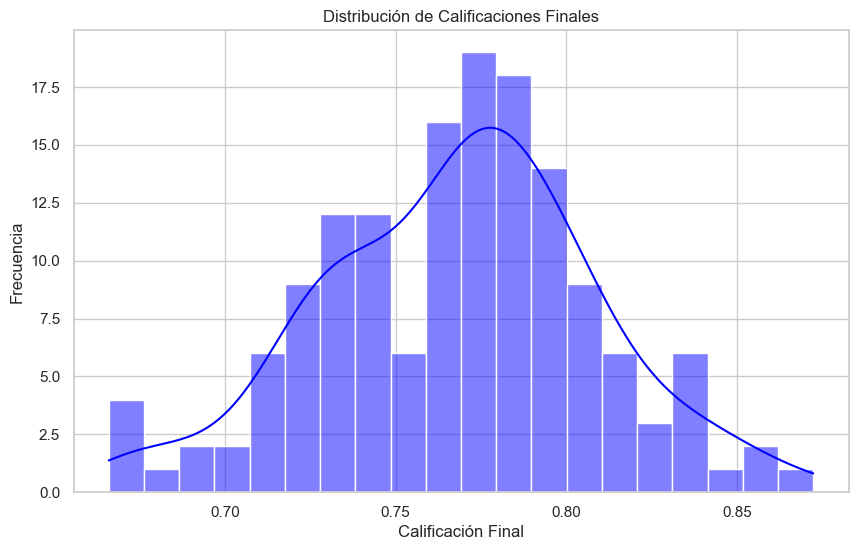

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas['FINAL_SCORE'], bins=20, kde=True, color='blue')
plt.title('Distribución de Calificaciones Finales')
plt.xlabel('Calificación Final')
plt.ylabel('Frecuencia')
plt.show()


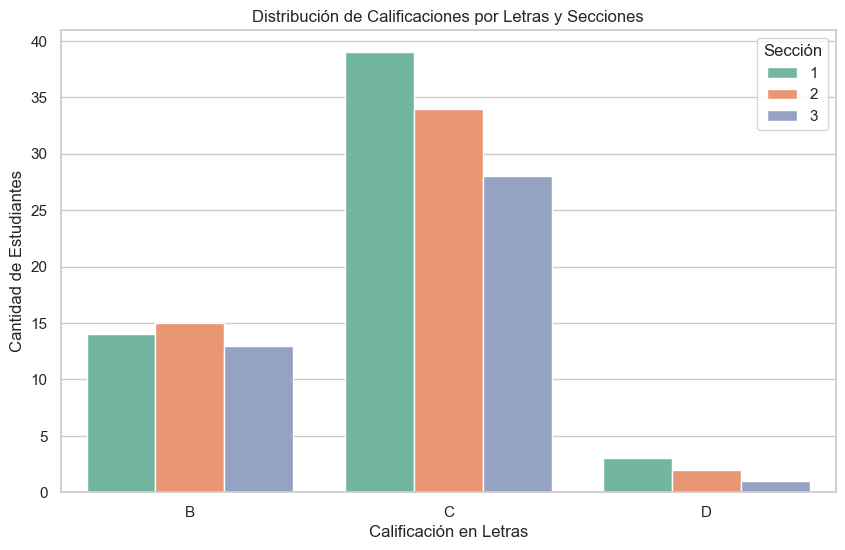

In [22]:
# Definir una paleta de colores que distinga las secciones
palette = sns.color_palette("Set2", n_colors=3)  # Ajusta 'n_colors' según el número de secciones

plt.figure(figsize=(10, 6))
sns.countplot(x='FINAL_GRADE', data=df_pandas, hue='SECTION', palette=palette)
plt.title('Distribución de Calificaciones por Letras y Secciones')
plt.xlabel('Calificación en Letras')
plt.ylabel('Cantidad de Estudiantes')
plt.legend(title='Sección')
plt.show()

C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_11792\57522434.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FINAL_GRADE', y='FINAL_SCORE', data=df_pandas, palette='coolwarm')


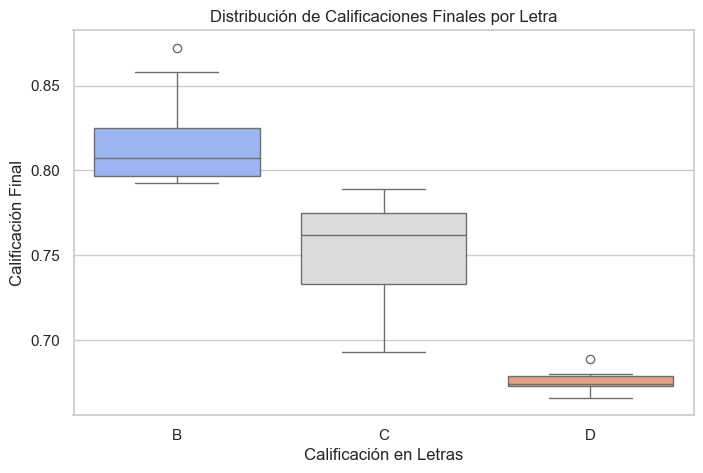

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='FINAL_GRADE', y='FINAL_SCORE', data=df_pandas, palette='coolwarm')
plt.title('Distribución de Calificaciones Finales por Letra')
plt.xlabel('Calificación en Letras')
plt.ylabel('Calificación Final')
plt.show()


In [24]:
df_aggregated = df_spark.groupBy("FINAL_GRADE", "SECTION").agg({"FINAL_SCORE": "avg"})
df_aggregated.show()


+-----------+-------+------------------+
|FINAL_GRADE|SECTION|  avg(FINAL_SCORE)|
+-----------+-------+------------------+
|          C|      3|0.7597812168409721|
|          D|      2|0.6817698664503012|
|          C|      1|0.7506105722412628|
|          B|      1|0.8155273014593439|
|          B|      3|0.8193120739072145|
|          C|      2|0.7544985139838083|
|          D|      3|0.6801927144535841|
|          D|      1|0.6705909620950541|
|          B|      2|0.8099656019449881|
+-----------+-------+------------------+



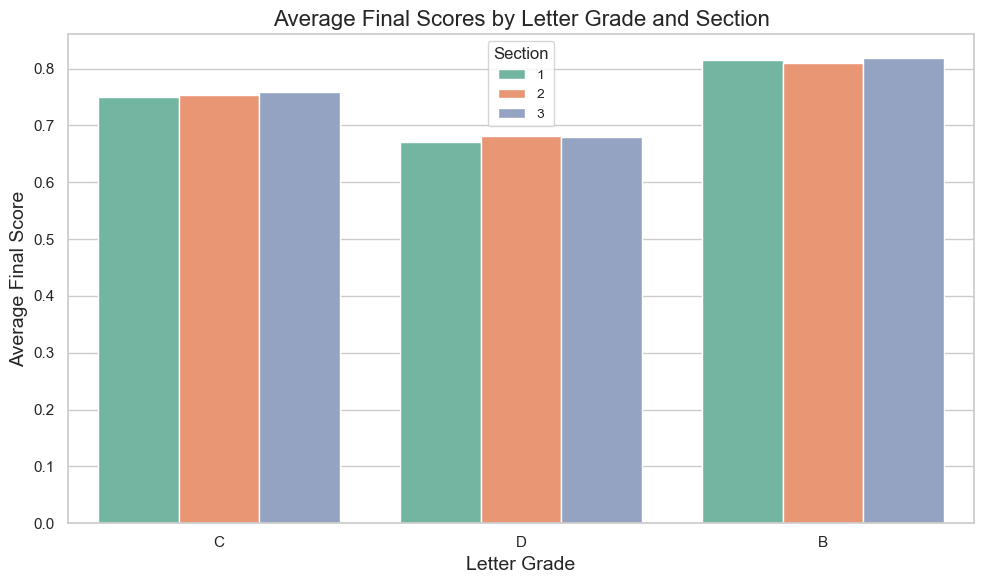

In [25]:
df_aggregated_pandas = df_aggregated.toPandas()

# Define a palette that can accommodate the number of sections
# Adjust 'n_colors' based on the number of unique sections
palette = sns.color_palette("Set2", n_colors=df_aggregated_pandas['SECTION'].nunique())

plt.figure(figsize=(10, 6))
sns.barplot(
    x='FINAL_GRADE',
    y='avg(FINAL_SCORE)',
    hue='SECTION',
    data=df_aggregated_pandas,
    palette=palette
)
plt.title('Average Final Scores by Letter Grade and Section', fontsize=16)
plt.xlabel('Letter Grade', fontsize=14)
plt.ylabel('Average Final Score', fontsize=14)
plt.legend(title='Section', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()

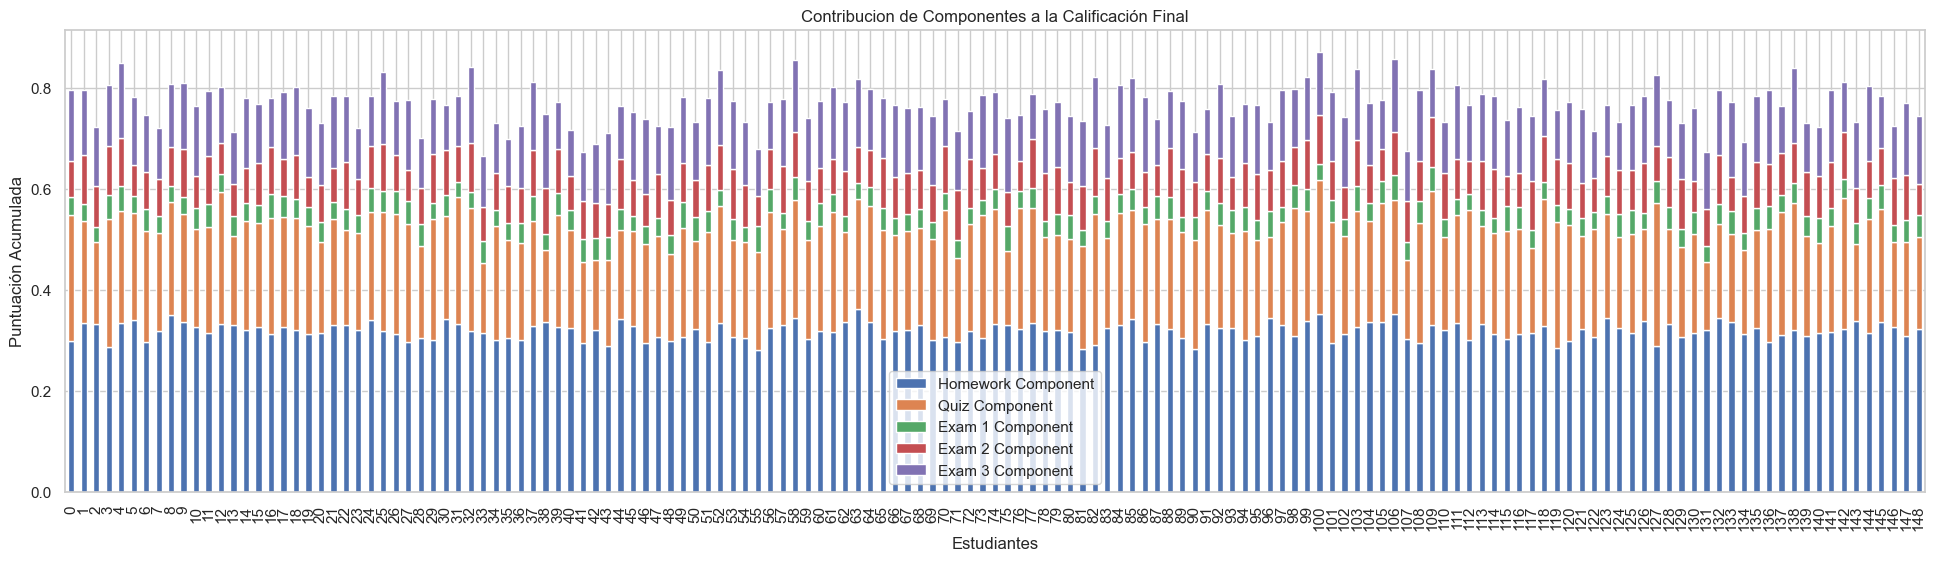

In [26]:
df_pandas['Homework Component'] = df_pandas['HOMEWORK_SCORE'] * 0.4
df_pandas['Quiz Component'] = df_pandas['QUIZ_SCORE'] * 0.3
df_pandas['Exam 1 Component'] = df_pandas['EXAM_1_SCORE'] * 0.05
df_pandas['Exam 2 Component'] = df_pandas['EXAM_2_SCORE'] * 0.1
df_pandas['Exam 3 Component'] = df_pandas['EXAM_3_SCORE'] * 0.15

component_columns = ['Homework Component', 'Quiz Component', 'Exam 1 Component', 'Exam 2 Component', 'Exam 3 Component']

df_pandas[component_columns].plot(kind='bar', stacked=True, figsize=(24, 6))
plt.title('Contribucion de Componentes a la Calificación Final')
plt.xlabel('Estudiantes')
plt.ylabel('Puntuación Acumulada')
plt.show()


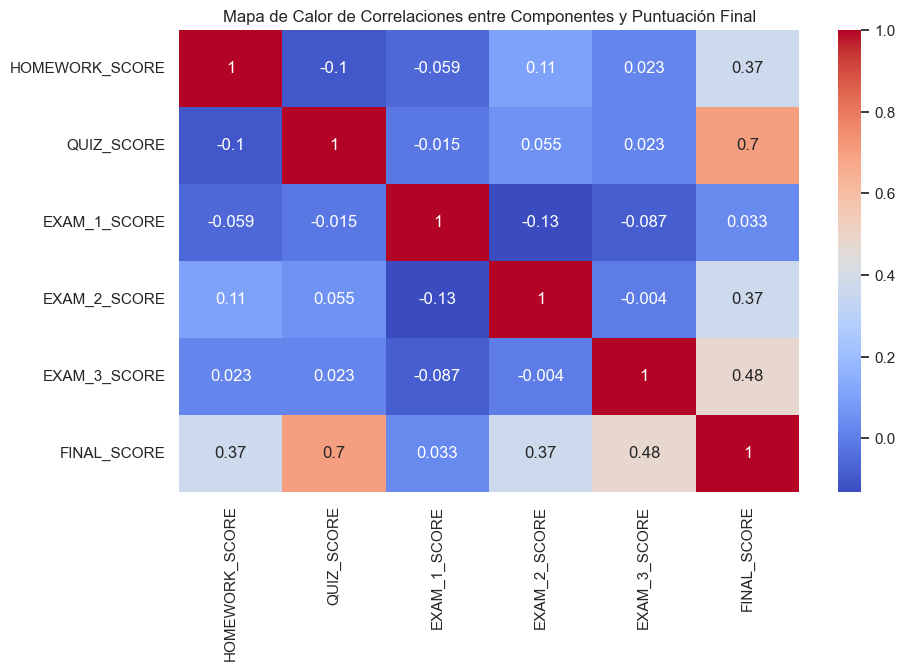

In [18]:
correlation_matrix = df_pandas[['HOMEWORK_SCORE', 'QUIZ_SCORE', 'EXAM_1_SCORE', 'EXAM_2_SCORE', 'EXAM_3_SCORE', 'FINAL_SCORE']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones entre Componentes y Puntuación Final')
plt.show()


# Quiz

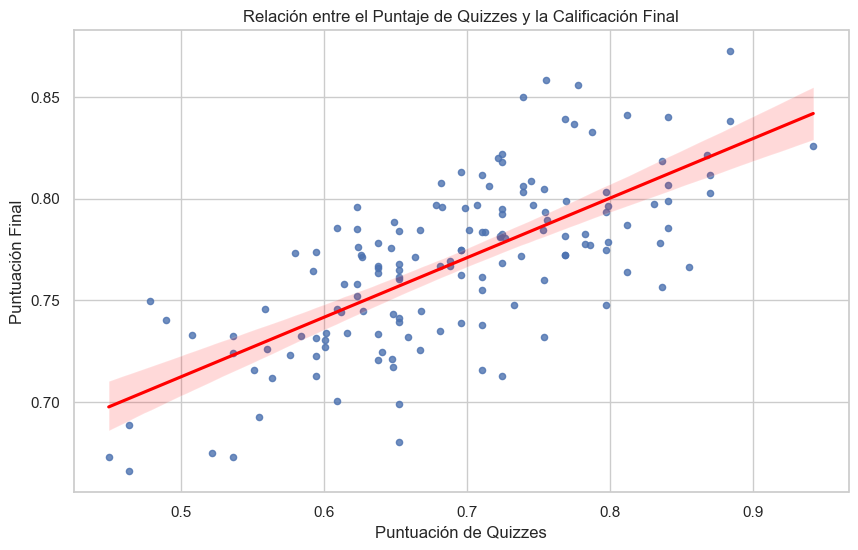

In [19]:
plt.figure(figsize=(10, 6))
sns.regplot(x='QUIZ_SCORE', y='FINAL_SCORE', data=df_pandas, scatter_kws={'s':20}, line_kws={'color':'red'})
plt.title('Relación entre el Puntaje de Quizzes y la Calificación Final')
plt.xlabel('Puntuación de Quizzes')
plt.ylabel('Puntuación Final')
plt.show()


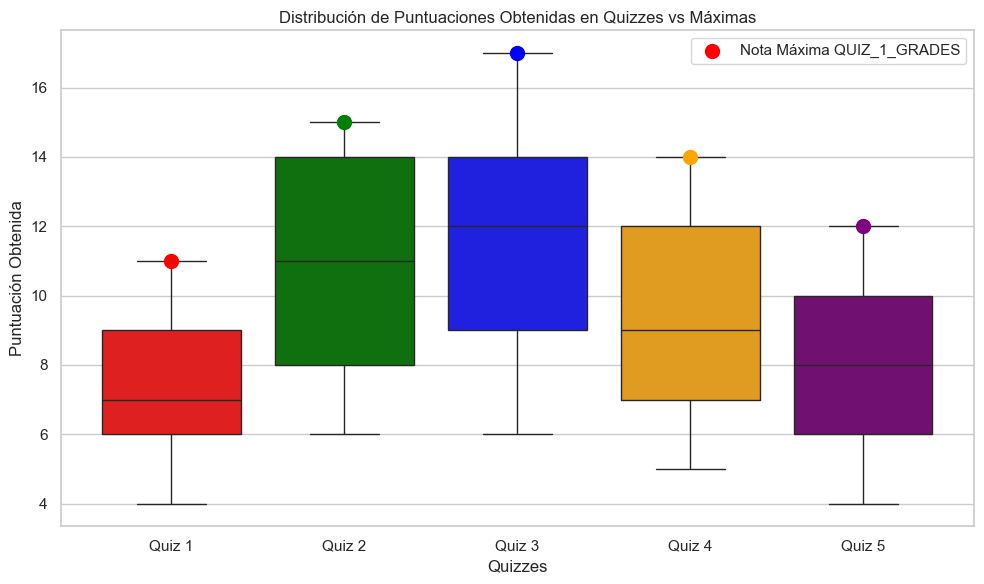

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Seleccionar las columnas de los quizzes
quiz_columns = ["QUIZ_1_GRADES", "QUIZ_2_GRADES", "QUIZ_3_GRADES", "QUIZ_4_GRADES", "QUIZ_5_GRADES"]
quiz_max_points = [11, 15, 17, 14, 12]  # Puntuaciones máximas por quiz
df_quizz = df_spark.select("SID", *quiz_columns).toPandas()

quiz_max_points = [11, 15, 17, 14, 12]
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Crear el boxplot
plt.figure(figsize=(10, 6))

# Usar los mismos colores para las cajas y las líneas
sns.boxplot(data=df_quizz[quiz_columns], palette=colors)

# Añadir las líneas de puntuaciones máximas con los mismos colores
for i, (max_point, color) in enumerate(zip(quiz_max_points, colors)):
    plt.scatter(i, max_point, color=color, s=100, marker='o', zorder=5, label=f'Nota Máxima {quiz_columns[i]}' if i == 0 else "")

# Etiquetas y título
plt.title('Distribución de Puntuaciones Obtenidas en Quizzes vs Máximas')
plt.xlabel('Quizzes')
plt.ylabel('Puntuación Obtenida')
plt.xticks([0, 1, 2, 3, 4], ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5'])

plt.tight_layout()
plt.legend()
plt.show()

C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_11792\664215010.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas[quiz], shade=True, label=f"{quiz}", color=color, alpha=0.6)
C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_11792\664215010.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas[quiz], shade=True, label=f"{quiz}", color=color, alpha=0.6)
C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_11792\664215010.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas[quiz], shade=True, label=f"{quiz}", color=color, alpha=0.6)
C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_11792\

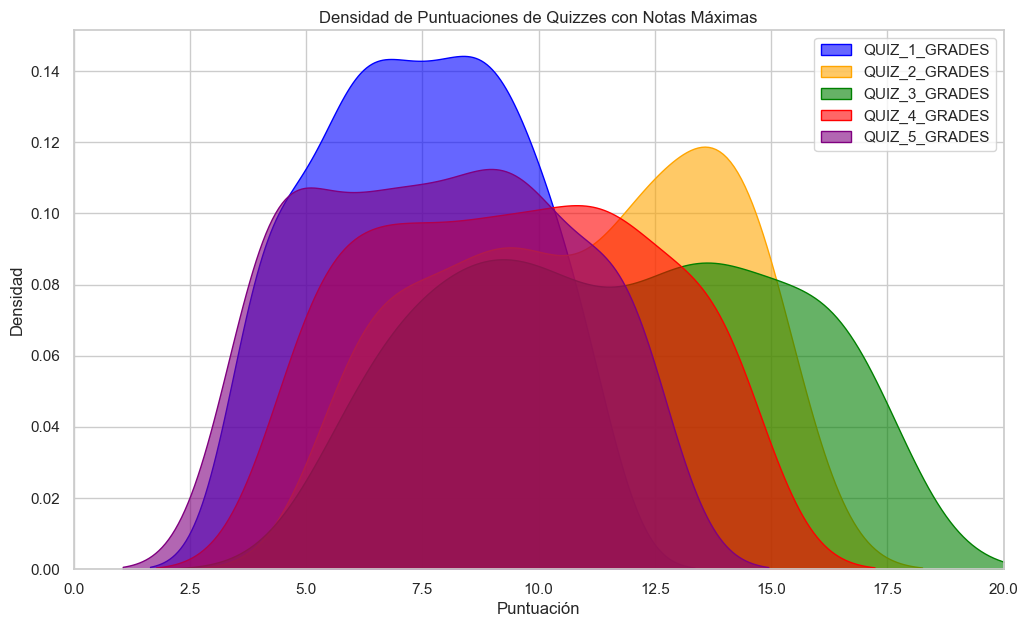

In [28]:
quiz_columns = ["QUIZ_1_GRADES", "QUIZ_2_GRADES", "QUIZ_3_GRADES", "QUIZ_4_GRADES", "QUIZ_5_GRADES"]
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(12, 7))

# Graficar la densidad de cada quiz con transparencia
for quiz, color in zip(quiz_columns, colors):
    sns.kdeplot(df_pandas[quiz], shade=True, label=f"{quiz}", color=color, alpha=0.6)
# Configurar títulos y leyendas
plt.title("Densidad de Puntuaciones de Quizzes con Notas Máximas")
plt.xlabel("Puntuación")
plt.ylabel("Densidad")
plt.xlim(0, 20)  # Ajustar los límites del eje X si es necesario
plt.legend()
plt.show()

# HomeWork

C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_10108\1653590912.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas[homework], shade=True, label=f"{homework} (Max: {max_point})", color=color, alpha=0.6)
C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_10108\1653590912.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas[homework], shade=True, label=f"{homework} (Max: {max_point})", color=color, alpha=0.6)
C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_10108\1653590912.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas[homework], shade=True, label=f"{homework} (Max: {max_point

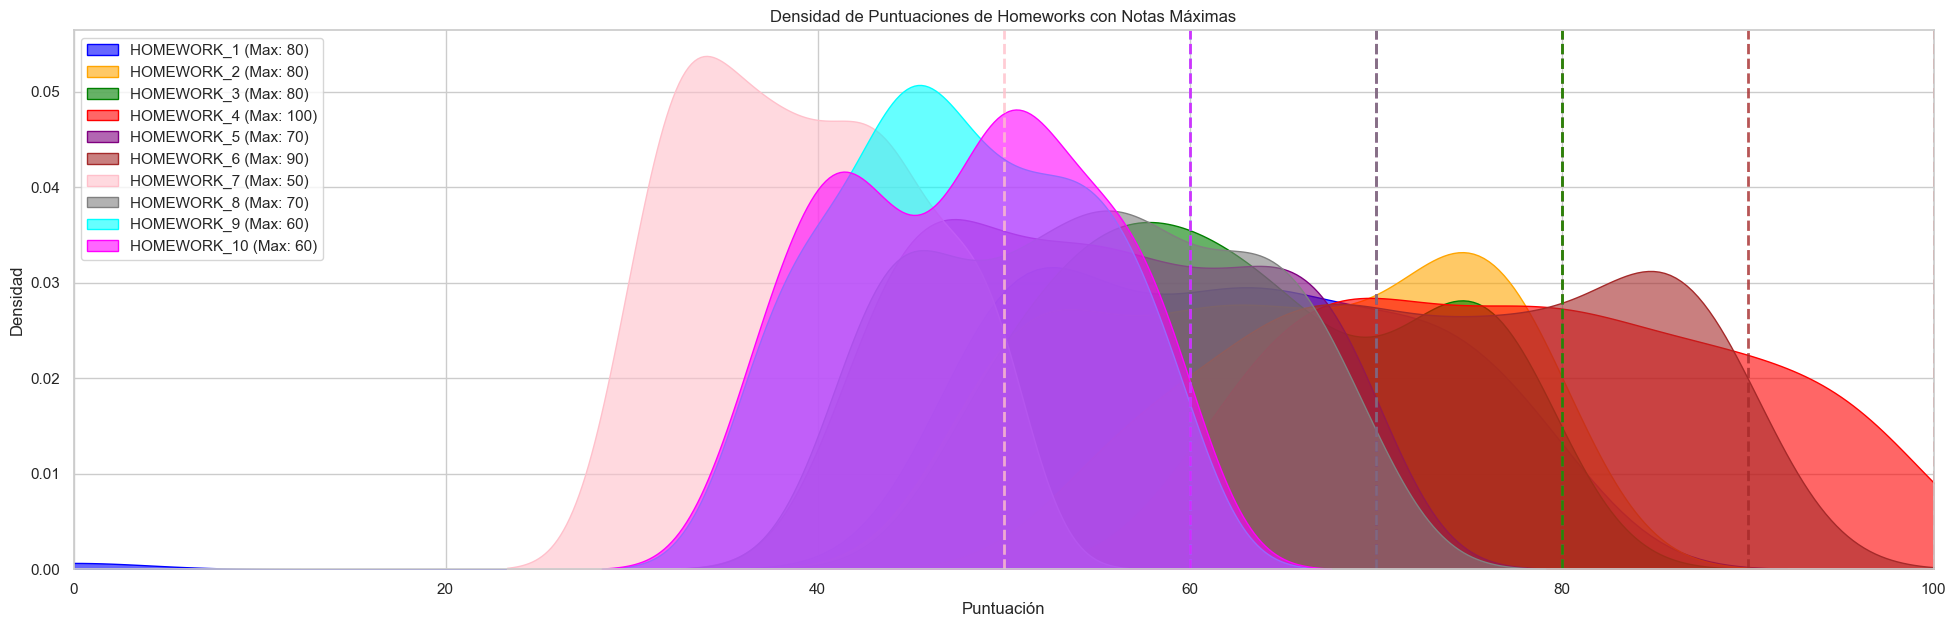

In [76]:
# Definir las puntuaciones máximas de los Homeworks
homework_max_points = [80, 80, 80, 100, 70, 90, 50, 70, 60, 60]  # Notas máximas de cada homework
homework_columns = [
    'HOMEWORK_1', 'HOMEWORK_2', 'HOMEWORK_3', 'HOMEWORK_4', 
    'HOMEWORK_5', 'HOMEWORK_6', 'HOMEWORK_7', 'HOMEWORK_8', 
    'HOMEWORK_9', 'HOMEWORK_10'
]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

plt.figure(figsize=(24, 7))

# Graficar la densidad de cada homework
for homework, max_point, color in zip(homework_columns, homework_max_points, colors):
    sns.kdeplot(df_pandas[homework], shade=True, label=f"{homework} (Max: {max_point})", color=color, alpha=0.6)
    
    # Añadir línea de referencia para la nota máxima de cada homework
    plt.axvline(x=max_point, color=color, linestyle='--', lw=2, alpha=0.8)

# Configurar títulos y leyendas
plt.title("Densidad de Puntuaciones de Homeworks con Notas Máximas")
plt.xlabel("Puntuación")
plt.ylabel("Densidad")
plt.xlim(0, 100)  # Ajustar los límites del eje X según las puntuaciones de homework
plt.legend()
plt.show()


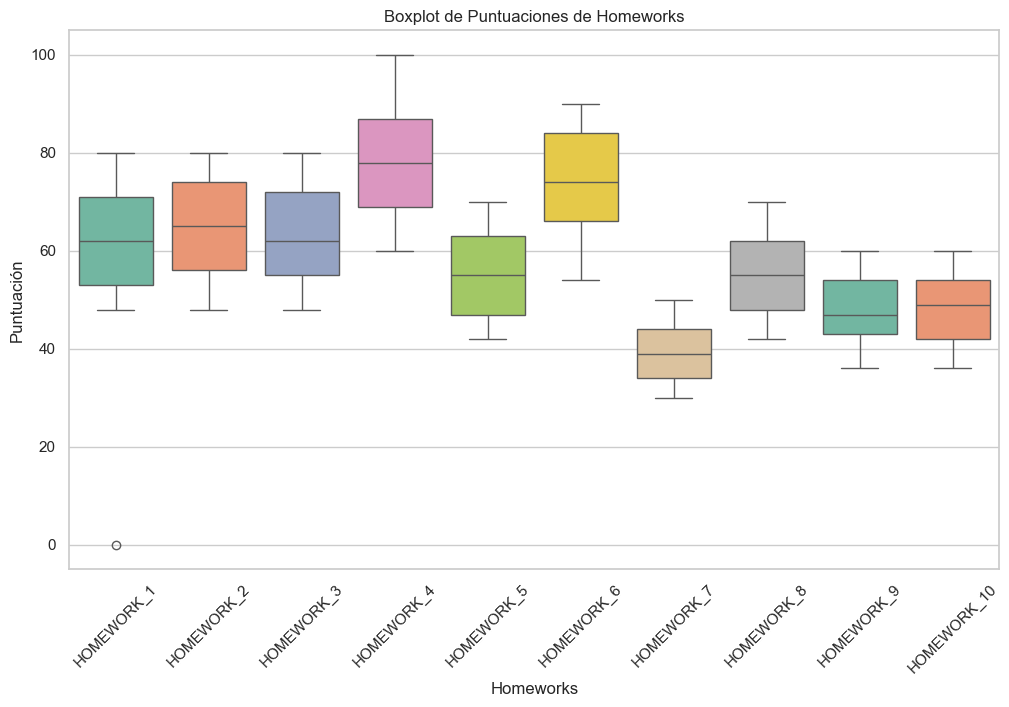

In [84]:
plt.figure(figsize=(12, 7))

# Graficar el boxplot para las puntuaciones de cada homework
sns.boxplot(data=df_pandas[homework_columns], palette="Set2")

# Configurar títulos y leyendas
plt.title("Boxplot de Puntuaciones de Homeworks")
plt.xlabel("Homeworks")
plt.ylabel("Puntuación")
plt.xticks(rotation=45)
plt.show()


C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_10108\497280344.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=avg_homework_scores.index, y=avg_homework_scores.values, palette="coolwarm")


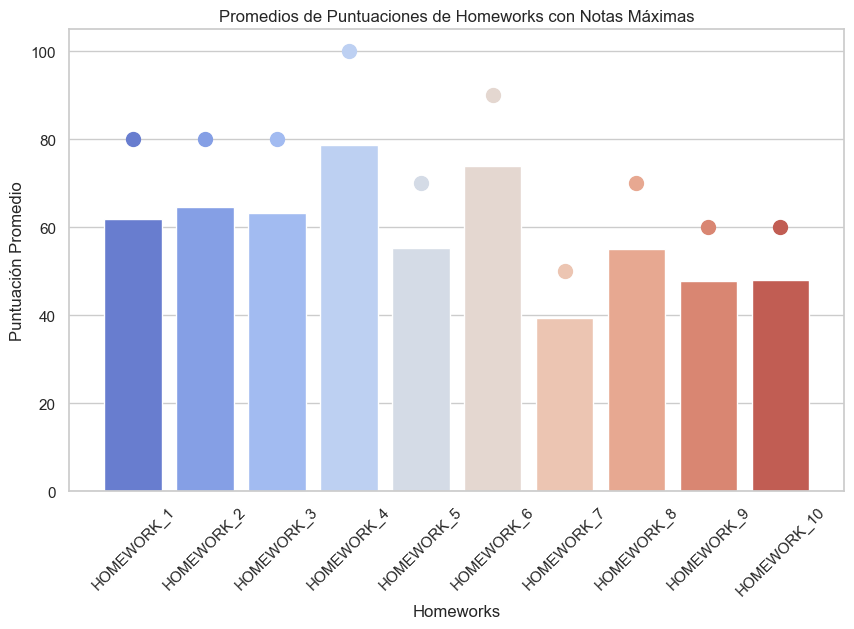

In [85]:
# Puntuaciones máximas de cada homework
homework_max_scores = [80, 80, 80, 100, 70, 90, 50, 70, 60, 60]  # Ajusta los valores según corresponda

# Calcular los promedios de cada homework
avg_homework_scores = df_pandas[homework_columns].mean()

plt.figure(figsize=(10, 6))

# Graficar el barplot de los promedios de homeworks
barplot = sns.barplot(x=avg_homework_scores.index, y=avg_homework_scores.values, palette="coolwarm")

# Obtener los colores de las barras
palette = [bar.get_facecolor() for bar in barplot.patches]

# Añadir puntos para las puntuaciones máximas de cada homework con los mismos colores
for i, (max_score, color) in enumerate(zip(homework_max_scores, palette)):
    plt.scatter(i, max_score, color=color, s=100, marker='o', zorder=5, label=f'Nota Máxima {homework_columns[i]}' if i == 0 else "")

# Configurar títulos y leyendas
plt.title("Promedios de Puntuaciones de Homeworks con Notas Máximas")
plt.xlabel("Homeworks")
plt.ylabel("Puntuación Promedio")
plt.xticks(rotation=45)

plt.show()


# Exams

C:\Users\bruno.fajardo\AppData\Local\Temp\ipykernel_10108\3765896990.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=avg_exam_scores.index, y=avg_exam_scores.values, palette="coolwarm")


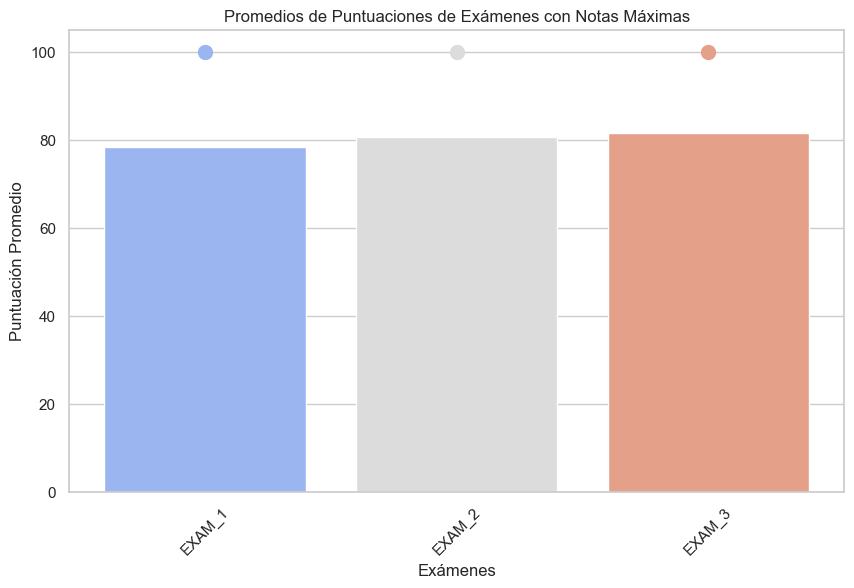

In [86]:
exam_columns = ['EXAM_1', 'EXAM_2', 'EXAM_3']
exam_max_scores = [100, 100, 100]
avg_exam_scores = df_pandas[exam_columns].mean()
plt.figure(figsize=(10, 6))

# Graficar el barplot de los promedios de exámenes
barplot = sns.barplot(x=avg_exam_scores.index, y=avg_exam_scores.values, palette="coolwarm")

# Obtener los colores de las barras
palette = [bar.get_facecolor() for bar in barplot.patches]

# Añadir puntos para las puntuaciones máximas de cada examen con los mismos colores
for i, (max_score, color) in enumerate(zip(exam_max_scores, palette)):
    plt.scatter(i, max_score, color=color, s=100, marker='o', zorder=5)

# Configurar títulos y leyendas
plt.title("Promedios de Puntuaciones de Exámenes con Notas Máximas")
plt.xlabel("Exámenes")
plt.ylabel("Puntuación Promedio")
plt.xticks(rotation=45)

plt.show()


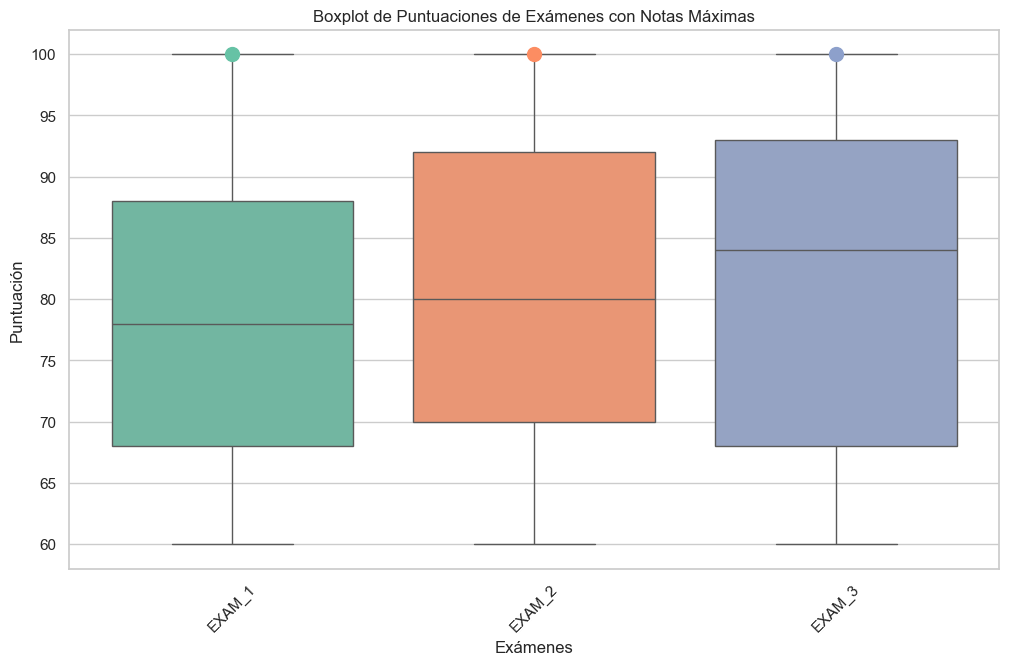

In [87]:
plt.figure(figsize=(12, 7))

# Graficar el boxplot para las puntuaciones de cada examen
sns.boxplot(data=df_pandas[exam_columns], palette="Set2")

# Añadir puntos para las notas máximas de cada examen con los mismos colores que el boxplot
for i, (max_score, color) in enumerate(zip(exam_max_scores, sns.color_palette("Set2", len(exam_columns)))):
    plt.scatter(i, max_score, color=color, s=100, marker='o', zorder=5)

# Configurar títulos y leyendas
plt.title("Boxplot de Puntuaciones de Exámenes con Notas Máximas")
plt.xlabel("Exámenes")
plt.ylabel("Puntuación")
plt.xticks(rotation=45)

plt.show()
